In [2]:
import pickle

import time
import pandas as pd
import numpy as np
import re
import spacy
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.help import upenn_tagset
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize,MWETokenizer

from gensim import corpora, models, matutils
from corextopic import corextopic as ct
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scattertext as st

In [8]:
df_tweet_copy= pd.read_pickle('tweets_malone.pkl')
df_tweet_copy.columns

Index(['author_id', 'username', 'author_followers', 'author_followings',
       'author_tweets', 'author_description', 'author_location', 'text',
       'created_at', 'retweets', 'replies', 'likes', 'quote_count'],
      dtype='object')

In [9]:
df_tweet = df_tweet_copy.copy()
df_tweet.shape

(22938, 13)

In [397]:
df_tweet.head()

,author_id,username,author_followers,author_followings,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,1316931193,thekapnobatai,12,88,5820,Connecting Through The Clouds,None,"Dr. Robert Malone: ""The government is now lawl...",2022-01-14 17:47:15+00:00,0,0,0,0
1,136772697,wgaryjohnson,142,893,6566,,None,@jessicamalaty @Spotify @joerogan I'm sure Rog...,2022-01-14 17:47:02+00:00,0,0,0,0
2,867042174,chemTrailActivi,2106,2790,28117,Meeting like-minded citizens who'll fight for ...,"Arizona, USA",“How #Melatonin Prevents #Sepsis”\nMelatonin S...,2022-01-14 17:46:52+00:00,0,0,0,0
3,1377753958933000192,DFoe99,104,703,8636,"If you're a liberal, LOL = You're a fucking id...",None,@jessicamalaty @bethlinas @DrKatEpi I would re...,2022-01-14 17:46:39+00:00,0,0,0,0
4,17266544,bourbonroad,3297,4999,131767,"Screenwriter, Producer, Marketing Manager, Singer","Montclair, CA",@bart_e_anderson @rebel_ess @mtaibbi Hmmm...ha...,2022-01-14 17:45:58+00:00,0,0,0,0


## Data Cleaning and EDA

### Clean text tweet

In [10]:
class pre_clean_text:
    def __init__(self,docs):
        self.docs = docs
    
    def at_list(self):
        
        return [re.findall('@\S+',text) for i,text in enumerate(self.docs)]
    
    def clean_text(self):
        corpus =[]
        for i,text in enumerate(self.docs):
            text = re.sub('@\S+',"",text)  #delete @tage
            text = re.sub('#\S+',"",text)  #delete #
            text = re.sub('-'," ",text)  
            text = re.sub('  '," ",text)
            text = re.sub('http\S+',"",text) # delet url
            text = re.sub(r"&amp;", "and", text)
            #text = re.sub('[%s2+]' % re.escape(string.punctuation), ' ',text) #delete pucuration
            pattern= re.compile('(([!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~])\\2+)')
            match = pattern.search(text)
            if match:
                text=text.replace(match.group(1), ".")

            text = re.sub('\n',"",text).replace("  "," ").replace("\n"," ") # delete spaces
            text = text.lower()
            corpus.append(text)
        return corpus
        

In [11]:
tweet_at_list  = pre_clean_text(df_tweet.text).at_list()
tweet_at_list[:5]

[[],
 ['@jessicamalaty', '@Spotify', '@joerogan'],
 ['@Mercola'],
 ['@jessicamalaty', '@bethlinas', '@DrKatEpi'],
 ['@bart_e_anderson',
  '@rebel_ess',
  '@mtaibbi',
  '@joerogan',
  '@P_McCulloughMD']]

In [12]:
# Save origal tweet text

#orignal_tweet = df_tweet.text

In [13]:
tweet_corpus = pre_clean_text(df_tweet.text).clean_text()
tweet_corpus[:5]

['dr. robert malone: "the government is now lawless!"',
 " i'm sure rogan would be happy to have you on and give you the opportunity straighten dr malone out in person. why not give it a shot?",
 '“how prevents melatonin significantly reduces covid 19 mortalityby dr. joseph ++',
 " i would really love to see you debate dr. malone so that those of us who are vaccine hesitant can understand why you believe it's safe and effective without just saying it's safe and effective.",
 ' hmmm.have you listened to the interviews ith and dr. malone?']

In [14]:
author_description_corpus = pre_clean_text(df_tweet.author_description).clean_text()
author_description_corpus[:5]

['connecting through the clouds',
 '',
 "meeting like minded citizens who'll fight for clean chemtrail free blue skies in the valley of the sun and elsewhere. posting proof getting us nowhere. action",
 "if you're a liberal, lol = you're a fucking idiot. if you're normal, lol = that's funny.",
 'screenwriter, producer, marketing manager, singer']

In [15]:
df_tweet['description_corpus'] = author_description_corpus
df_tweet['@list'] = tweet_at_list
df_tweet['tweet_corpus'] = tweet_corpus

In [16]:
test_list = list(df_tweet.author_location)
df_tweet.author_location = [str(i or '') for i in test_list]
df_tweet.shape

(22938, 16)

In [17]:
df_tweet.drop_duplicates(subset=['tweet_corpus'],inplace=True,ignore_index= True)
df_tweet.shape

(17563, 16)

In [18]:
df_tweet.index

RangeIndex(start=0, stop=17563, step=1)

In [19]:
sum(df_tweet.description_corpus== "")

3825

# Sentiment Analysis

### General attitude

In [20]:
analyzer  = SentimentIntensityAnalyzer()
sentiment_score = [analyzer.polarity_scores(text).
                   get('compound') for i,text in enumerate(df_tweet['tweet_corpus'])]

In [21]:
df_tweet['sentiment_score'] = sentiment_score
df_tweet.head()

,author_id,username,author_followers,author_followings,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,description_corpus,@list,tweet_corpus,sentiment_score
0,1316931193,thekapnobatai,12,88,5820,Connecting Through The Clouds,,"Dr. Robert Malone: ""The government is now lawl...",2022-01-14 17:47:15+00:00,0,0,0,0,connecting through the clouds,[],"dr. robert malone: ""the government is now lawl...",0.0000
1,136772697,wgaryjohnson,142,893,6566,,,@jessicamalaty @Spotify @joerogan I'm sure Rog...,2022-01-14 17:47:02+00:00,0,0,0,0,,"[@jessicamalaty, @Spotify, @joerogan]",i'm sure rogan would be happy to have you on ...,0.8316
2,867042174,chemTrailActivi,2106,2790,28117,Meeting like-minded citizens who'll fight for ...,"Arizona, USA",“How #Melatonin Prevents #Sepsis”\nMelatonin S...,2022-01-14 17:46:52+00:00,0,0,0,0,meeting like minded citizens who'll fight for ...,[@Mercola],“how prevents melatonin significantly reduces ...,0.0772
3,1377753958933000192,DFoe99,104,703,8636,"If you're a liberal, LOL = You're a fucking id...",,@jessicamalaty @bethlinas @DrKatEpi I would re...,2022-01-14 17:46:39+00:00,0,0,0,0,"if you're a liberal, lol = you're a fucking id...","[@jessicamalaty, @bethlinas, @DrKatEpi]",i would really love to see you debate dr. mal...,0.9381
4,17266544,bourbonroad,3297,4999,131767,"Screenwriter, Producer, Marketing Manager, Singer","Montclair, CA",@bart_e_anderson @rebel_ess @mtaibbi Hmmm...ha...,2022-01-14 17:45:58+00:00,0,0,0,0,"screenwriter, producer, marketing manager, singer","[@bart_e_anderson, @rebel_ess, @mtaibbi, @joer...",hmmm.have you listened to the interviews ith ...,0.0000


In [22]:
 #[analyzer.polarity_scores(text) for i,text in enumerate(df_tweet['tweet_corpus'])]

Text(0.5, 1.0, 'Histogram plot of sentiment score ')

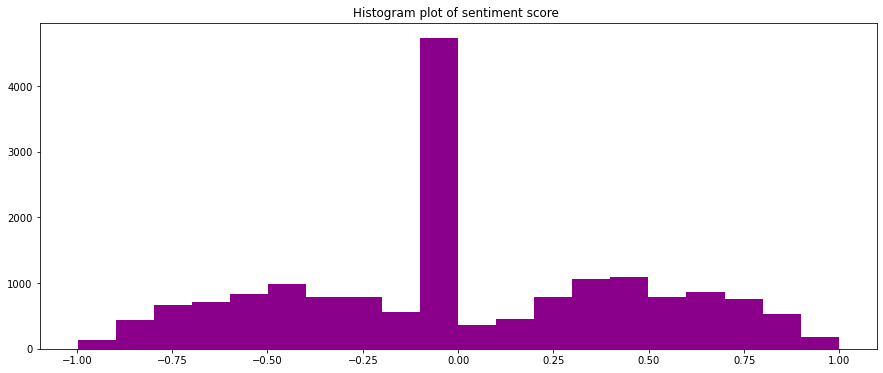

In [27]:
plt.figure(figsize= (15,6))
plt.hist(df_tweet.sentiment_score,bins=20,color='darkmagenta')
plt.title ("Histogram plot of sentiment score ")

In [412]:
bins = [-1,-.05,.05,1]
labels = ['negative', 'neutural','positive']

In [413]:
df_tweet['attitude'] = (pd.cut(df_tweet.sentiment_score,
                                      bins = bins,
                                      labels = labels,
                                     include_lowest=True))
df_tweet.head()

,author_id,username,author_followers,author_followings,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,description_corpus,@list,tweet_corpus,sentiment_score,attitude
0,1316931193,thekapnobatai,12,88,5820,Connecting Through The Clouds,,"Dr. Robert Malone: ""The government is now lawl...",2022-01-14 17:47:15+00:00,0,0,0,0,connecting through the clouds,[],"dr. robert malone: ""the government is now lawl...",0.0000,neutural
1,136772697,wgaryjohnson,142,893,6566,,,@jessicamalaty @Spotify @joerogan I'm sure Rog...,2022-01-14 17:47:02+00:00,0,0,0,0,,"[@jessicamalaty, @Spotify, @joerogan]",i'm sure rogan would be happy to have you on ...,0.8316,positive
2,867042174,chemTrailActivi,2106,2790,28117,Meeting like-minded citizens who'll fight for ...,"Arizona, USA",“How #Melatonin Prevents #Sepsis”\nMelatonin S...,2022-01-14 17:46:52+00:00,0,0,0,0,meeting like minded citizens who'll fight for ...,[@Mercola],“how prevents melatonin significantly reduces ...,0.0772,positive
3,1377753958933000192,DFoe99,104,703,8636,"If you're a liberal, LOL = You're a fucking id...",,@jessicamalaty @bethlinas @DrKatEpi I would re...,2022-01-14 17:46:39+00:00,0,0,0,0,"if you're a liberal, lol = you're a fucking id...","[@jessicamalaty, @bethlinas, @DrKatEpi]",i would really love to see you debate dr. mal...,0.9381,positive
4,17266544,bourbonroad,3297,4999,131767,"Screenwriter, Producer, Marketing Manager, Singer","Montclair, CA",@bart_e_anderson @rebel_ess @mtaibbi Hmmm...ha...,2022-01-14 17:45:58+00:00,0,0,0,0,"screenwriter, producer, marketing manager, singer","[@bart_e_anderson, @rebel_ess, @mtaibbi, @joer...",hmmm.have you listened to the interviews ith ...,0.0000,neutural


In [414]:
df_neg_tweet = df_tweet[df_tweet.sentiment_score < -0.05]

df_pos_tweet = df_tweet[df_tweet.sentiment_score > 0.05]

df_neg_tweet.shape ,df_pos_tweet.shape

((6135, 18), (6770, 18))

In [415]:
#df_tweet.to_csv('df_tweet.csv')

### Scatter text

In [416]:
df_scatter = pd.concat([df_neg_tweet,df_pos_tweet])


In [417]:
scatter_corpus = st.CorpusFromPandas(df_scatter,
                             category_col='attitude',
                             text_col='tweet_corpus',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [418]:
html = st.produce_scattertext_explorer(
        scatter_corpus,
        category='positive',
        category_name='positive',
        not_category_name='negative',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        )

In [419]:
open('tweet_scatter.html', 'wb').write(html.encode('utf-8'));

## Word cloud 

### User self discriptions

In [39]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests

In [40]:
# This function takes in your text and your mask and generates a wordcloud. 

def generate_wordcloud(words):
    word_cloud = WordCloud(width = 512, height = 256, background_color='white', stopwords=STOPWORDS).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

    
#mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/0/2/6/8/12597008542080209014demikl_3D_rounded_speech_bubble.svg.hi.png', stream=True).raw))


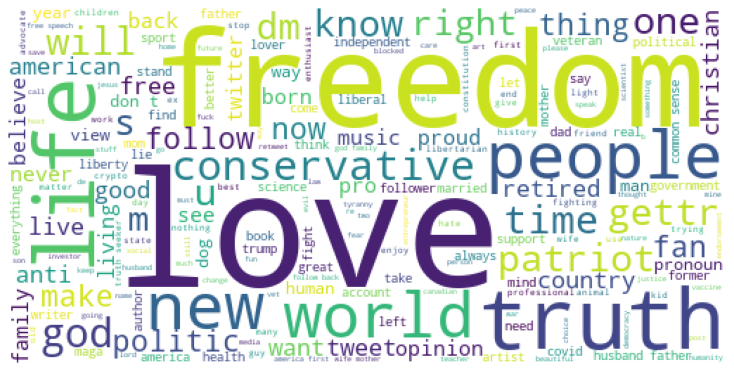

In [41]:
words = " ".join(df_tweet.description_corpus)
generate_wordcloud(words)

### Amod and advmod extraction and Word cloud about subjects

In [31]:
nlp = spacy.load('en_core_web_sm')
spacy_doc = list(nlp.pipe(df_tweet.tweet_corpus))

In [32]:
%matplotlib inline
import random

In [48]:
class key_word_analysis:
    def __init__(self):
        self.noun_str  = " "
        self.docs = " "
        self.amod_list = []
        self.head_list = []
        self.l_list = []
        self.score_list  = []
        self.pos_senti =[]
        self.neg_senti = []

    def fit(self,noun_str, docs):
        self.noun_str  = noun_str
        self.docs = docs      
        for i,doc in enumerate(self.docs):
            for token in doc:
                if token.text == noun_str :
                    for child in token.children:
                        #if child.dep_ == 'amod' or child.dep_ =='advmod':
                         if   child.dep_ in ['amod','advmod','attr','acomp']:
                            senti_socre = analyzer.polarity_scores(child.text).get('compound')
                            self.amod_list.append(child.text.lower())
                            self.l_list.append(i)
                            self.score_list.append(senti_socre)
                    if token.head.dep_ == 'amod' or token.head.dep_ == 'conj'or token.head.dep_ == 'acomp':
                        self.head_list.append(token.head.text)
        print(len(self.amod_list),len(self.head_list))

    def word_cloud(self):
        words = " ".join(self.amod_list)
        print(" "* 20,f"Words clouds about {self.noun_str}","\n")
        generate_wordcloud(words)
        generate_wordcloud(" ".join(self.head_list))
# return amod_list,head_list,score_list
    
    def sample_tweet(self,n):
        t1,t2,t3 =self.amod_list,self.l_list,self.score_list
        #plot histogram plot of sentiment scores
        sns.histplot(t3)
        df_senti = pd.DataFrame([t1,t2,t3]).transpose()
        df_senti.columns = ['amod','user_index','senti_score']
        pos_senti = df_senti[df_senti.senti_score> .05]
        neg_senti = df_senti[df_senti.senti_score < -0.05]
        
        
        print(f" \n sample of tweets hold positive attitude: \n")
        
#         for i in range(n):
#             index = random.choice(pos_senti.user_index.tolist())
#             print(i,index,":",df_tweet.tweet_corpus[index],"\n") 
        
        
        index = random.sample(pos_senti.user_index.tolist(),min(len(pos_senti.user_index.tolist()),n))
        for i,j in enumerate(index):
             print(i,j,":",df_tweet.tweet_corpus[j],"\n")
        
        
        
        print("*"*100,"\n",f"\n sample of tweets hold negative attitude:\n")
        index = random.sample(neg_senti.user_index.tolist(),min(len(neg_senti.user_index.tolist()),n))
        for i,j in enumerate(index):
             print(i,j,":",df_tweet.tweet_corpus[j],"\n")
                
                
        self.pos_senti = pos_senti
        self.neg_senti = neg_senti
    
    def check_users(self):
        pos_user=[]
        neg_user = []
        for i in self.pos_senti.user_index:
            pos_user.append(author_description_corpus[i])
        words = " ".join(pos_user)
        print(" "* 20,"Words clouds about positive users","\n")
        generate_wordcloud(words)
        for i in self.neg_senti.user_index:
            neg_user.append(author_description_corpus[i])
        words = " ".join(neg_user)
        print(" "* 20,"Words clouds about negative users","\n")
        generate_wordcloud(words)        

In [43]:
malone_analy =key_word_analysis() 
malone_analy.fit('malone',spacy_doc)

290 579


In [44]:
malone_analy.amod_list

['mccullough',
 'same',
 '|',
 'even',
 'powerful',
 'there',
 'mccullough',
 'there',
 'even',
 'even',
 'mccullough',
 'mccullough',
 'also',
 'bad',
 '|',
 'debunk',
 'regular',
 'listener.robert',
 'mccullough',
 'mccullough',
 'mccullough',
 'same',
 'same',
 'even',
 'actingdr',
 'lying',
 'then',
 'mccullough',
 'here',
 'on',
 'correct',
 'respected',
 'on',
 'mccullough',
 'unfortunately',
 'even',
 'even',
 'worth',
 'even',
 'only',
 'renowned',
 'controversial',
 'on',
 'on',
 'on',
 'pied',
 'even',
 'license?robert',
 'mccullough',
 'recently',
 'mccullough',
 'real',
 'critical',
 'good',
 'mccullough',
 'vaxxing',
 'you????dr.robert',
 'mccullough',
 'even',
 'credible',
 'especially',
 'only',
 'worth',
 'same',
 'on',
 'anti',
 '😑',
 'unethical',
 'disgruntled',
 'bad',
 'great',
 'then',
 'bigger',
 'then',
 'great',
 'now',
 'on',
 'now',
 'by',
 '🚨',
 'silenced',
 'debunked',
 'e.g.',
 'also',
 'even',
 'mccullough',
 'even',
 'ahead',
 'only',
 'ahead',
 'old',
 '

In [45]:

# parsed = nlp(u"Photos is great, both front and back cameras.")
# print(u'sentence:{0}'.format(parsed.text))
# print(u'parsed_sentence_children::{0}'.format([(x.text,x.pos_,x.dep_,[(y.text,y.dep_) for y in list(x.children)]) for x in parsed]))
# # print(u'parsed_sentence_ancestors::{0}'.format([(x.text,x.pos_,x.dep_,[(x.text,x.dep_) for x in list(x.ancestors)]) for x in parsed]))


                     Words clouds about malone 



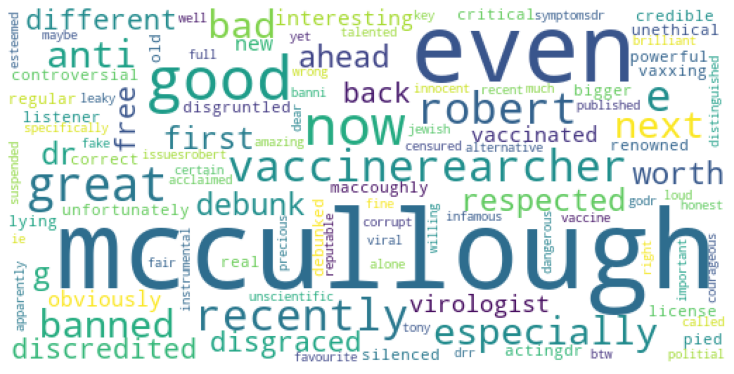

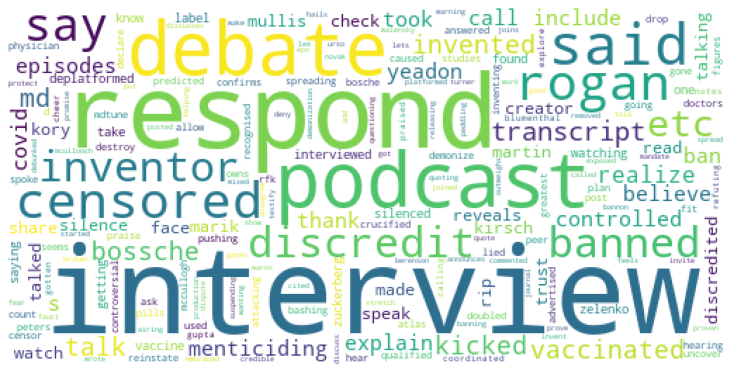

In [46]:
malone_analy.word_cloud()

 
 sample of tweets hold positive attitue: 

0 6256 : gettr: just this week, welcomed one and only and the biggest name in cable news to the platformgettr broke 4 million new users! reaching another amazing milestone!also t great dr malone, marjorie taylor greene,general flynn, stephen k bannon. 

1 15736 :  to be fair dr. malone mentions something similar. however, the point is bruce did faulty research for this article. hence, it can be assumed faulty work was used in his other work as well. 

2 2461 :  dr robert malone, well worth a follow on gettr. 

3 10130 : aren’t anti vaccine mandate marches the result of mass formation psychosis, dear robert malone, marchers basically “being hypnotized” to disbelieve established facts about covid 19? 

4 16706 :  you don't have to believe me. but go listen to the mccoullough report, his qanda really a lot about this. dr malone as well. i'm glad it was a mild variant that broke through, now, i'm sure i have super duper immunity. 

*************

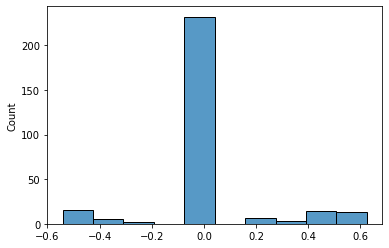

In [56]:
malone_analy.sample_tweet(5)

                     Words clouds about positive users 



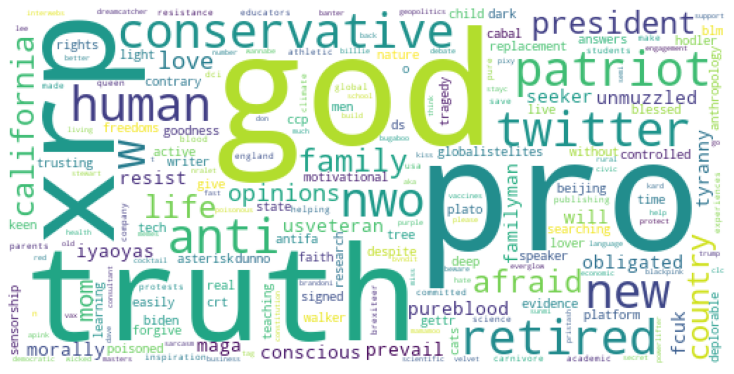

                     Words clouds about negative users 



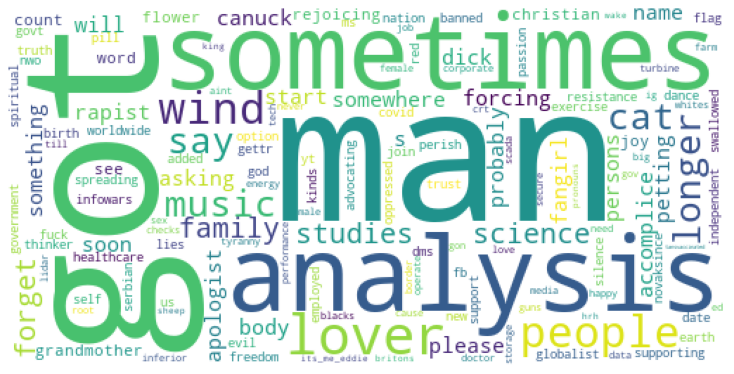

In [438]:
malone_analy.check_users()

In [439]:
# Save data

In [440]:
with open("df_tweet_clean.pkl",'wb') as file:
    pickle.dump(df_tweet,file)

In [441]:
df_tweet.shape

(17563, 18)

In [442]:
df_tweet.to_csv('df_tweet_clean.csv')

In [443]:
df_tweet

,author_id,username,author_followers,author_followings,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,description_corpus,@list,tweet_corpus,sentiment_score,attitude
0,1316931193,thekapnobatai,12,88,5820,Connecting Through The Clouds,,"Dr. Robert Malone: ""The government is now lawl...",2022-01-14 17:47:15+00:00,0,0,0,0,connecting through the clouds,[],"dr. robert malone: ""the government is now lawl...",0.0000,neutural
1,136772697,wgaryjohnson,142,893,6566,,,@jessicamalaty @Spotify @joerogan I'm sure Rog...,2022-01-14 17:47:02+00:00,0,0,0,0,,"[@jessicamalaty, @Spotify, @joerogan]",i'm sure rogan would be happy to have you on ...,0.8316,positive
2,867042174,chemTrailActivi,2106,2790,28117,Meeting like-minded citizens who'll fight for ...,"Arizona, USA",“How #Melatonin Prevents #Sepsis”\nMelatonin S...,2022-01-14 17:46:52+00:00,0,0,0,0,meeting like minded citizens who'll fight for ...,[@Mercola],“how prevents melatonin significantly reduces ...,0.0772,positive
3,1377753958933000192,DFoe99,104,703,8636,"If you're a liberal, LOL = You're a fucking id...",,@jessicamalaty @bethlinas @DrKatEpi I would re...,2022-01-14 17:46:39+00:00,0,0,0,0,"if you're a liberal, lol = you're a fucking id...","[@jessicamalaty, @bethlinas, @DrKatEpi]",i would really love to see you debate dr. mal...,0.9381,positive
4,17266544,bourbonroad,3297,4999,131767,"Screenwriter, Producer, Marketing Manager, Singer","Montclair, CA",@bart_e_anderson @rebel_ess @mtaibbi Hmmm...ha...,2022-01-14 17:45:58+00:00,0,0,0,0,"screenwriter, producer, marketing manager, singer","[@bart_e_anderson, @rebel_ess, @mtaibbi, @joer...",hmmm.have you listened to the interviews ith ...,0.0000,neutural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17558,975278425,RickBrant2,8,33,13,,"Edmonton, Alberta","I have never been a big fan of Twitter, but wi...",2022-01-07 17:54:35+00:00,0,0,0,0,,[],"i have never been a big fan of twitter, but wi...",-0.9200,negative
17559,1471982451064979456,kylesessing7,36,61,860,I'm Usually a A Foul Mouthed Viking Fan and ta...,USA,@BeardedFisherm1 Dr. Robert Malone would agree...,2022-01-07 17:54:29+00:00,0,1,1,0,i'm usually a a foul mouthed viking fan and ta...,[@BeardedFisherm1],dr. robert malone would agree with that as we...,0.1531,positive
17560,168573249,stinkydog480,78,316,17339,Dad and dedicated Youth baseball coach! Mounta...,"Mesa, AZ",@DanCrenshawTX @RepDanCrenshaw @SenateGOP @GOP...,2022-01-07 17:54:12+00:00,0,0,0,0,dad and dedicated youth baseball coach! mounta...,"[@DanCrenshawTX, @RepDanCrenshaw, @SenateGOP, ...",this is from msm! dr. malone been talking ab...,-0.5432,negative
17561,876851500818939904,StellarCEOS,92,159,1772,Bill McIntosh VALUETAINMENT Booker-Biggest Int...,"Lima, Peru",Pat we are over the target if they take down y...,2022-01-07 17:54:01+00:00,0,0,1,0,bill mcintosh valuetainment booker biggest int...,"[@SabinehazanMD, @AguilarSocial]",pat we are over the target if they take down y...,0.3707,positive
